In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
# Gráficos
# ==============================================================================
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Asunciones y Preprocesamiento
# ==============================================================================
from scipy import stats
import math
from scipy.stats import levene
import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools
# ANOVA
# ==============================================================================
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Linear Regresion con Sklearn
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('bikes_post_eda.csv', index_col=0)
df.head()

,season_encoding,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,...,hum,hum_interval,hum_interval_num,hum_interval_ord,windspeed,wind_interval,wind_num_encoding,casual,registered,cnt
0,1,winter,0,1,1,0,6,0,2,14.1,...,80.6,very_high,"(77.76, 97.2]",5,10.749882,low,1,331,654,985
1,1,winter,0,1,2,0,0,0,2,14.9,...,69.6,high,"(58.32, 77.76]",4,16.652113,medium,2,131,670,801
2,1,winter,0,1,3,0,1,1,1,8.1,...,43.7,medium,"(38.88, 58.32]",3,16.636703,medium,2,120,1229,1349
3,1,spring,0,1,4,0,2,1,1,8.2,...,59.0,high,"(58.32, 77.76]",4,10.739832,low,1,108,1454,1562
4,1,spring,0,1,5,0,3,1,1,9.3,...,43.7,medium,"(38.88, 58.32]",3,12.522300,low,1,82,1518,1600


### Dividimos el df en columnas categóricas y numéricas

 - Categóricas

In [4]:
df_cat = df.select_dtypes(include='object')
df_cat.head(2)

,season,temp_interval,temp_interval_num,hum_interval,hum_interval_num,wind_interval,wind_num_encoding
0,winter,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",low,1
1,winter,low,"(8.98, 15.56]",high,"(58.32, 77.76]",medium,2


 - Numéricas

In [5]:
df_num = df.select_dtypes(np.number)
df_num.head(2)

,season_encoding,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,temp_interval_ord,hum,hum_interval_ord,windspeed,casual,registered,cnt
0,1,0,1,1,0,6,0,2,14.1,2,80.6,5,10.749882,331,654,985
1,1,0,1,2,0,0,0,2,14.9,2,69.6,4,16.652113,131,670,801


### Proceso pre-ANOVA

#### Normalidad

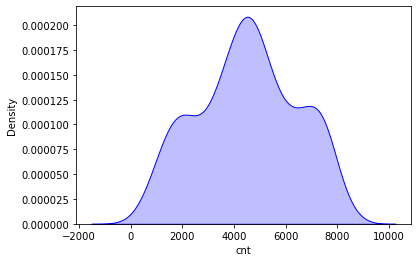

In [41]:
sns.distplot(
    df.cnt, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

 - Parece que la variable respuesta tiene una distribución normal.

In [42]:
stats.shapiro(df["cnt"])

ShapiroResult(statistic=0.9802490472793579, pvalue=2.313480784721378e-08)

 - Pero en el test de Shapiro dice que no lo son, así que vamos a normalizarlos.

In [43]:
df['cnt'], lambda_ajustada = stats.boxcox(df['cnt'])

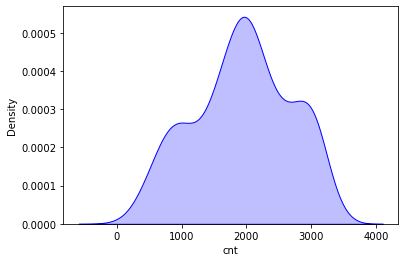

In [44]:
sns.distplot(
    df.cnt, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

In [45]:
stats.shapiro(df["cnt"])

ShapiroResult(statistic=0.9801719784736633, pvalue=2.1925126603150602e-08)

 - El p.value sigue estando muy por debajo de 0.05. ¿Quizás normalizar otra vez?

In [46]:
df['cnt'], lambda_ajustada = stats.boxcox(df['cnt'])

In [48]:
stats.shapiro(df["cnt"])

ShapiroResult(statistic=0.9801687598228455, pvalue=2.1876299882706007e-08)

 - No ha cambiado nada.

#### Homocedasticidad

 - Categóricas

IndexError: index 4 is out of bounds for axis 0 with size 4

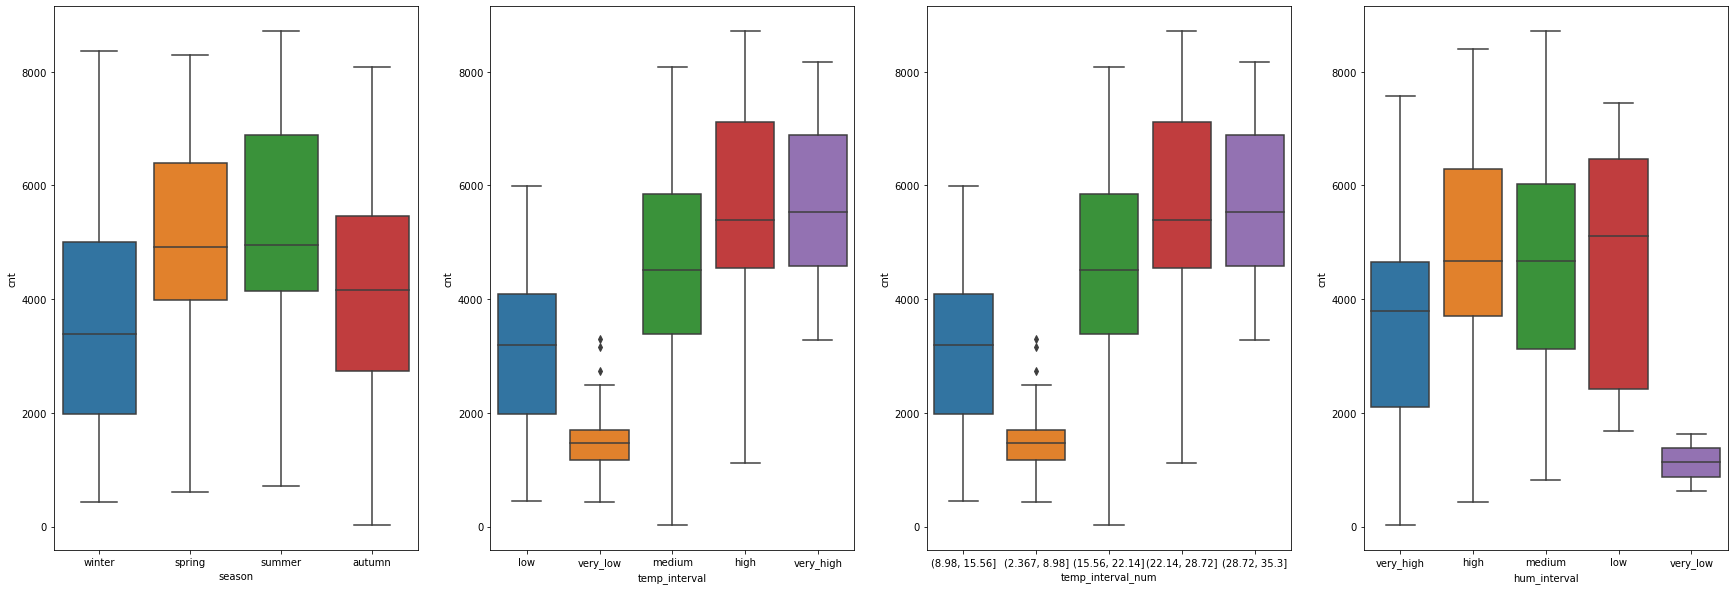

In [13]:
fig, axes = plt.subplots(1,4, figsize= (30,10))

axes = axes.flat

colum_cat = df.select_dtypes(include = ['object', 'category']).columns

for i, col in enumerate(colum_cat):
    sns.boxplot(
        x = col,
        y = 'cnt',
        data = df,
        palette = 'tab10',
        ax = axes[i]

    )

In [14]:
def datos_test_levene (columna, df):
    valores = df[columna].unique()
    d = {}

    for x in valores:
        d['{0}'.format(x)] = df[df[columna] == x]['cnt']
    return d

In [15]:
season = datos_test_levene('season', df)
temp_interval = datos_test_levene('temp_interval', df)
wind_interval = sexo = datos_test_levene('wind_interval', df)
hum_interval = sexo = datos_test_levene('hum_interval', df)


In [22]:
levene_season = stats.levene(season['winter'], season['spring'], season['summer'], season['autumn'], center='median')
levene_season

LeveneResult(statistic=1.7590626071065214, pvalue=0.15360584747469838)

In [23]:
levene_temp_interval = stats.levene(temp_interval['very_low'], temp_interval['low'], temp_interval['medium'], temp_interval['high'], temp_interval['very_high'], center='median')
levene_temp_interval

LeveneResult(statistic=11.874080007252433, pvalue=2.3834609259049677e-09)

In [24]:
levene_hum_interval = stats.levene(hum_interval['very_low'], hum_interval['low'], hum_interval['medium'], hum_interval['high'], hum_interval['very_high'], center='median')
levene_hum_interval

LeveneResult(statistic=2.105350915562837, pvalue=0.07846976473180971)

In [25]:
levene_wind_interval = stats.levene(wind_interval['very_low'], wind_interval['low'], wind_interval['medium'], wind_interval['high'], wind_interval['very_high'], center='median')
levene_wind_interval

LeveneResult(statistic=1.200711308639278, pvalue=0.3091382708367324)

    - Deberíamos incluir las variables season y wind_interval porque son las que tienen el p.valor > 0.05. La columna hum_interval tiene un p.valor de 0.078, ¿se incluye?

 - Numéricas

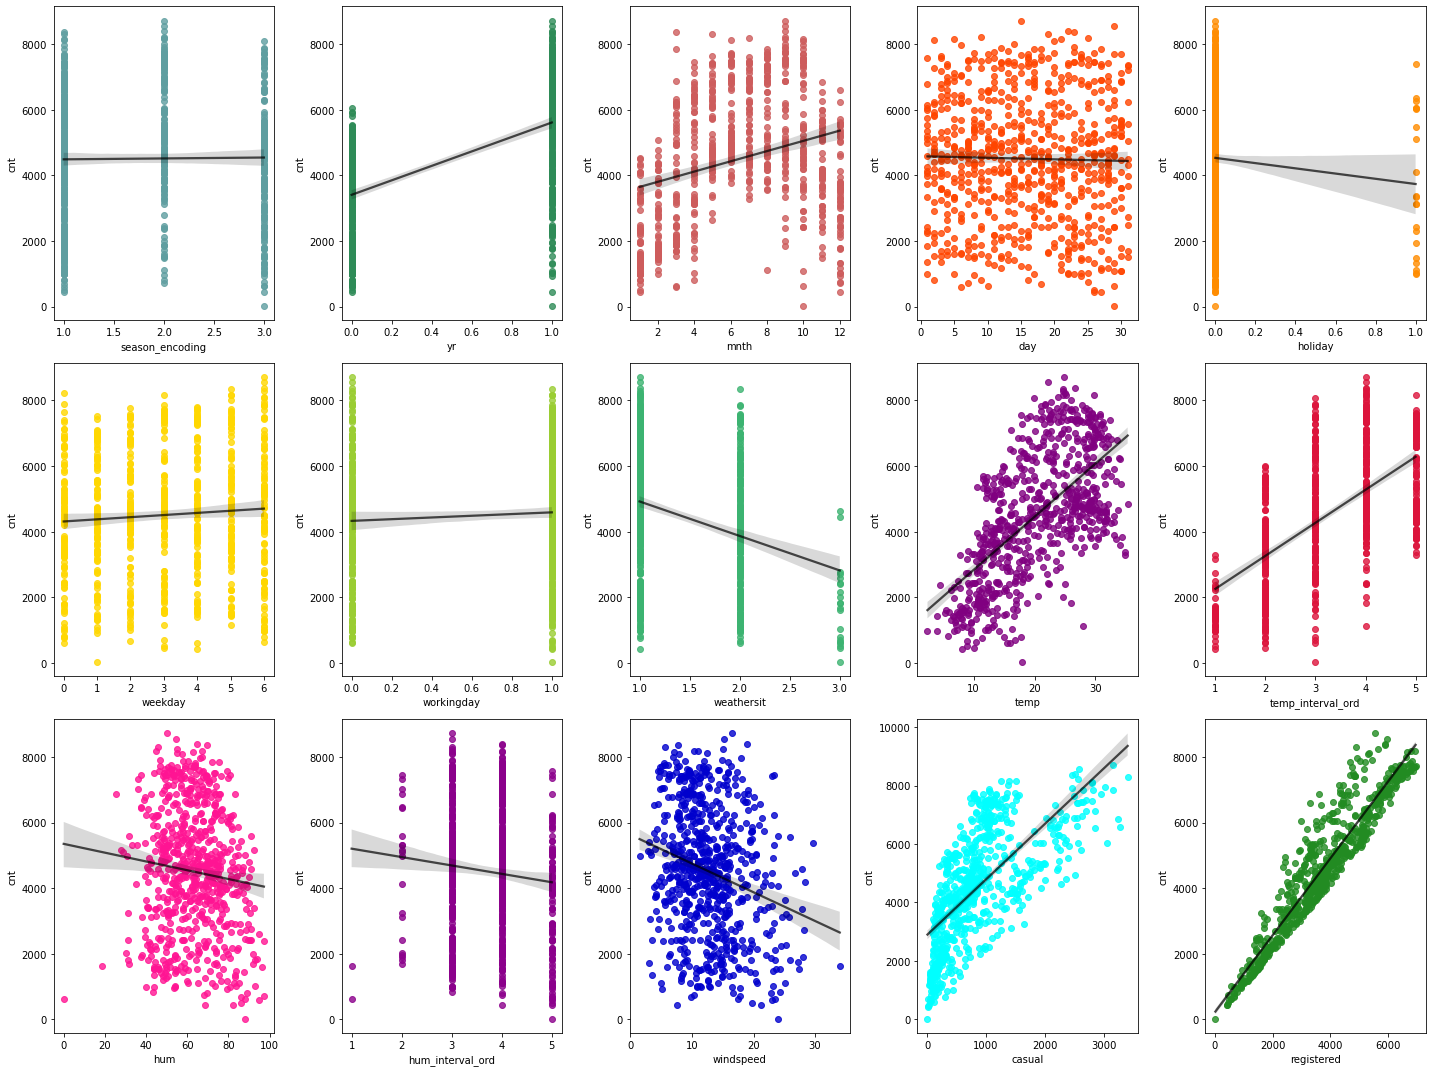

In [29]:
# iniciamos los subplots
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (20, 15))

# definimos una lista de colores. Cada color corresponderá a una gráfica
lista_colores = ["cadetblue", "seagreen", 'indianred', 'orangered', 'darkorange', 'gold', 'yellowgreen', 'mediumseagreen', 'purple', 'crimson', 'deeppink', 'darkmagenta', 'mediumblue', 'cyan', 'forestgreen']

# hemos creado una gráfica con varios subplots. Si queremos automatizar el proceso de relleno de cada uno de los plots
## podemos usar el método .flat. Lo que hace es aplanar los ejes para que queden en una única dimensión
## y luego los vamos rellenando. 
axes = axes.flat

# seleccionamos las columnas que queremos graficar
columnas_numeric = df.select_dtypes(include = np.number).drop('cnt', axis=1)
columnas_numeric = columnas_numeric.columns

# iniciamos un for loop para no tener que escribir la misma línea de código muchas veces
for i, colum in enumerate(columnas_numeric): 
    sns.regplot(
        data = df,
        x = colum,
        y = 'cnt',
        color = lista_colores[i],
        line_kws = {"color": "black", "alpha": 0.7 }, 
        ax = axes[i])

fig.tight_layout();

 - En base a las gráficas deberíamos incluir temp, hum, windspeed. Casual y registered son el paso previo a cnt. ¿Se deben incluir?

In [30]:
numer = df_num.columns.drop('cnt')

In [31]:
resultados = {}

for col in numer:                   #bucle for para hacer el test de levene en columnas numéricas
    stat, p_value = levene(df_num[col], df_num.cnt, center='median')

    resultados[col] = p_value

In [32]:
resultados

{'season_encoding': 1.7127463427854928e-221,
 'yr': 1.5274213964794415e-221,
 'mnth': 4.823769876689766e-221,
 'day': 4.093456833278303e-220,
 'holiday': 1.228812000205092e-221,
 'weekday': 2.6841048126566987e-221,
 'workingday': 1.4034088907459814e-221,
 'weathersit': 1.4549531050765028e-221,
 'temp': 2.483823693494982e-220,
 'temp_interval_ord': 1.9181815127957392e-221,
 'hum': 2.661966368264321e-219,
 'hum_interval_ord': 1.584631952993692e-221,
 'windspeed': 7.971838325935599e-221,
 'casual': 3.031094721085453e-106,
 'registered': 3.756413456870291e-09}

Los números que salen son muy, muy pequeños. No sé cuál vamos a poder utilizar.

#### Independencia

 - Categóricas

In [35]:
columnas = df_cat.columns

In [36]:
combinaciones = list(itertools.combinations(columnas, 2))       #para combinar las columnas entre ellas de dos en dos sin repeticiones
combinaciones

[('season', 'temp_interval'),
 ('season', 'temp_interval_num'),
 ('season', 'hum_interval'),
 ('season', 'hum_interval_num'),
 ('season', 'wind_interval'),
 ('season', 'wind_num_encoding'),
 ('temp_interval', 'temp_interval_num'),
 ('temp_interval', 'hum_interval'),
 ('temp_interval', 'hum_interval_num'),
 ('temp_interval', 'wind_interval'),
 ('temp_interval', 'wind_num_encoding'),
 ('temp_interval_num', 'hum_interval'),
 ('temp_interval_num', 'hum_interval_num'),
 ('temp_interval_num', 'wind_interval'),
 ('temp_interval_num', 'wind_num_encoding'),
 ('hum_interval', 'hum_interval_num'),
 ('hum_interval', 'wind_interval'),
 ('hum_interval', 'wind_num_encoding'),
 ('hum_interval_num', 'wind_interval'),
 ('hum_interval_num', 'wind_num_encoding'),
 ('wind_interval', 'wind_num_encoding')]

In [37]:
for par in combinaciones:
    crosstab, test_results, expected = rp.crosstab(df[par[0]], df[par[1]],
                                                    test='chi-square', 
                                                    expected_freqs= True,
                                                    prop='cell')

    print('---------------------------', par[0], par[1],'-------------------')
    print(test_results)

--------------------------- season temp_interval -------------------
                 Chi-square test   results
0  Pearson Chi-square ( 12.0) =   212.2189
1                     p-value =     0.0000
2                  Cramer's V =     0.3113
--------------------------- season temp_interval_num -------------------
                 Chi-square test   results
0  Pearson Chi-square ( 12.0) =   212.2189
1                     p-value =     0.0000
2                  Cramer's V =     0.3113
--------------------------- season hum_interval -------------------
                 Chi-square test  results
0  Pearson Chi-square ( 12.0) =   20.4701
1                     p-value =    0.0587
2                  Cramer's V =    0.0967
--------------------------- season hum_interval_num -------------------
                 Chi-square test  results
0  Pearson Chi-square ( 12.0) =   20.4701
1                     p-value =    0.0587
2                  Cramer's V =    0.0967
--------------------------- season win

 - Si el p-value es > 0.05 significa que las variables son independientes y cumplen la asunción.
 - Correlaciones:
    - Season -- hum_interval (p.value > 0.05)

 - Numéricas

In [38]:
columnas_num = df_num.columns

In [39]:
combinaciones = list(itertools.combinations(columnas_num, 2))       #para combinar las columnas entre ellas de dos en dos sin repeticiones
combinaciones

[('season_encoding', 'yr'),
 ('season_encoding', 'mnth'),
 ('season_encoding', 'day'),
 ('season_encoding', 'holiday'),
 ('season_encoding', 'weekday'),
 ('season_encoding', 'workingday'),
 ('season_encoding', 'weathersit'),
 ('season_encoding', 'temp'),
 ('season_encoding', 'temp_interval_ord'),
 ('season_encoding', 'hum'),
 ('season_encoding', 'hum_interval_ord'),
 ('season_encoding', 'windspeed'),
 ('season_encoding', 'casual'),
 ('season_encoding', 'registered'),
 ('season_encoding', 'cnt'),
 ('yr', 'mnth'),
 ('yr', 'day'),
 ('yr', 'holiday'),
 ('yr', 'weekday'),
 ('yr', 'workingday'),
 ('yr', 'weathersit'),
 ('yr', 'temp'),
 ('yr', 'temp_interval_ord'),
 ('yr', 'hum'),
 ('yr', 'hum_interval_ord'),
 ('yr', 'windspeed'),
 ('yr', 'casual'),
 ('yr', 'registered'),
 ('yr', 'cnt'),
 ('mnth', 'day'),
 ('mnth', 'holiday'),
 ('mnth', 'weekday'),
 ('mnth', 'workingday'),
 ('mnth', 'weathersit'),
 ('mnth', 'temp'),
 ('mnth', 'temp_interval_ord'),
 ('mnth', 'hum'),
 ('mnth', 'hum_interval_ord

In [40]:
for par in combinaciones:
    crosstab, test_results, expected = rp.crosstab(df[par[0]], df[par[1]],
                                                    test='chi-square', 
                                                    expected_freqs= True,
                                                    prop='cell')

    print('---------------------------', par[0], par[1],'-------------------')
    print(test_results)

--------------------------- season_encoding yr -------------------
                Chi-square test  results
0  Pearson Chi-square ( 2.0) =       0.0
1                    p-value =       1.0
2                 Cramer's V =       0.0
--------------------------- season_encoding mnth -------------------
                 Chi-square test   results
0  Pearson Chi-square ( 22.0) =   538.1860
1                     p-value =     0.0000
2                  Cramer's V =     0.6071
--------------------------- season_encoding day -------------------
                 Chi-square test   results
0  Pearson Chi-square ( 60.0) =   574.2717
1                     p-value =     0.0000
2                  Cramer's V =     0.6272
--------------------------- season_encoding holiday -------------------
                Chi-square test  results
0  Pearson Chi-square ( 2.0) =    4.8133
1                    p-value =    0.0901
2                 Cramer's V =    0.0812
--------------------------- season_encoding weekday 

 - Correlaciones:
    - Podemos observar que las columnas year, season, mnth y day tienen el p.valor por encima de 0.05 y el valor de Cramer más alto de 0.5

### Resumen

 - Ninguna de las columnas tiene datos normales, y por mucho que los normalice no cambia esa situación. 
 - En cuanto a la homocedesticidad, se deben incluir season, temp, windspeed y hum. Son las que cumplen las condiciones.
 - Con respecto a la independencia: year, season, mnth, day y hum responden. Season y hum entre ellas, las demás con las columnas numéricas (season, temp, windspeed y hum).